In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import os
from pathlib import Path
from sklearn.feature_extraction.text import CountVectorizer

from tensorflow.keras.preprocessing.text import text_to_word_sequence, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense,Embedding,Input,Dropout,Conv1D
from tensorflow.keras.layers import SpatialDropout1D, Flatten,LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from sklearn.metrics import roc_auc_score
from tensorflow.keras.utils import plot_model

In [3]:
# Load your Numpy arrays
FS_labels = np.load('./data/FS_labels.npy', allow_pickle=True)
FS_test = np.load('./data/FS_test.npy', allow_pickle=True)
FS_train = np.load('./data/FS_train.npy', allow_pickle=True)

In [4]:
# Create the training DataFrame
train_df = pd.DataFrame(FS_train, columns=["text"])
train_df['label'] = FS_labels

# Create the test DataFrame
test_df = pd.DataFrame(FS_test, columns=["text"])

In [5]:
# Create embedding index from file in .txt format. First line contains 
# dictionary size and embedding dim. Fields are space separated
def get_embeddings(file_name):
    embeddings_index = {}
    with open(file_name, encoding="utf8") as f:
        for line in f:
            values = line.rstrip().split(' ')
            if len(values) > 2:
                embeddings_index[values[0]] = np.asarray(values[1:], dtype="float32")
    return embeddings_index
embeddings_path = "./crawl-300d-2M.vec"
embeddings_index = get_embeddings(embeddings_path)

In [6]:
import string
trans_table = str.maketrans({key: ' ' for key in string.digits + '\r\n' +
                             string.punctuation.replace("\'",'')})
def preprocess(text):
    return ' '.join(text.lower().translate(trans_table).split(' '))

In [28]:
### PROCESS TRAINING DATA

from sklearn.feature_extraction.text import CountVectorizer

UNKNOWN_PROXY = 'unknown'
MIN_WORD_OCCURRENCE = 5

train_df['description'] = train_df.text.apply(preprocess)
print("Creating the vocabulary of words occurred more than", MIN_WORD_OCCURRENCE)

vectorizer = CountVectorizer(lowercase=False, token_pattern="\S+", 
                             min_df=MIN_WORD_OCCURRENCE)
vectorizer.fit(train_df.description)

top_words = set(vectorizer.vocabulary_.keys())
top_words.add(UNKNOWN_PROXY)
print(len(top_words),'top words')


### APPLY TO TEST DATA
test_df['description'] = test_df.text.apply(preprocess)

Creating the vocabulary of words occurred more than 5
27005 top words


In [29]:
print('First 10 out of "top_words": \n',list(top_words)[:10])
print('\nIs "unknown" in top_words? \n','unknown' in top_words)

First 10 out of "top_words": 
 ['bush', 'toronto', 'crazy', 'pawn', 'rais', 'pahathmoab', 'unreal', 'uncomfortably', 'greece', 'limit']

Is "unknown" in top_words? 
 True


In [30]:
def filter_unknown(text, vocabulary, proxy):
    return ' '. \
join([w if w in vocabulary else proxy for w in text.split(' ')])

In [31]:
train_df['description'] = train_df.description.apply(filter_unknown,
                args=(set(embeddings_index.keys() & top_words), \
                      UNKNOWN_PROXY))

test_df['description'] = test_df.description.apply(filter_unknown,
                args=(set(embeddings_index.keys() & top_words), \
                      UNKNOWN_PROXY))

In [32]:
tokenizer = Tokenizer(filters="")
tokenizer.fit_on_texts(train_df.description)
print(tokenizer)

In [33]:
word_index = tokenizer.word_index
print(len(word_index))
list(word_index.items())[:16]

25195


[('unknown', 1),
 ('the', 2),
 ('and', 3),
 ('of', 4),
 ('to', 5),
 ('a', 6),
 ('in', 7),
 ('that', 8),
 ('he', 9),
 ('i', 10),
 ('it', 11),
 ('for', 12),
 ('his', 13),
 ('was', 14),
 ('is', 15),
 ('with', 16)]

In [34]:
MAX_SEQUENCE_LENGTH = 50
seq = tokenizer.texts_to_sequences(train_df.description)
data = pad_sequences(seq,maxlen=MAX_SEQUENCE_LENGTH,padding='post',
                     truncating='post')
with open('./text_data.pkl','wb') as f: pickle.dump(data, f, -1)

seq_test = tokenizer.texts_to_sequences(test_df.description)
data_test = pad_sequences(seq_test,maxlen=MAX_SEQUENCE_LENGTH,padding='post', truncating='post')
with open('./text_test_data.pkl','wb') as f: pickle.dump(data, f, -1)

print('\nFirst 2 sequences in `seq`: ',seq[:2])
print('\nShape of `data`: ',data.shape)
print('\nFirst prepared text in `data`:',data[0])


First 2 sequences in `seq`:  [[1, 1, 1, 1, 1, 1, 1, 57, 50, 17, 10984, 7, 2, 161, 1, 57, 50, 17, 4011, 1, 57, 50, 17, 11749, 1, 41, 16393, 1, 8912, 1, 41, 19723, 1, 1, 57, 42, 747, 11750, 35, 7, 2, 456, 4, 42, 161, 1, 1, 1807, 1886, 41, 1807, 5296, 50, 17, 1, 1, 1, 1, 1, 1, 1, 1, 1, 63, 59, 1501, 41, 59, 5060, 9595, 36, 17, 98, 4, 79, 60, 1, 41, 4, 23, 71, 105, 142, 1, 51, 112, 47, 36, 103, 13, 128, 1886, 3, 13, 128, 3242, 1, 3, 36, 821, 246, 13, 248, 7, 32, 108, 1, 1, 1, 1, 1, 1, 1, 1, 1, 63, 236, 62, 33, 257, 71, 2942, 169, 1, 3, 2038, 1, 3, 3687, 49, 112, 60, 305, 49, 23, 13, 620, 1, 291, 203, 62, 2326, 1, 1, 1, 1, 12, 62, 86, 2326, 2, 1263, 4, 2, 140, 4, 109, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 24, 94, 377, 75, 1, 5, 489, 7, 71, 620, 1, 46, 143, 18, 24, 405, 7, 2, 161, 34, 62, 6079, 49, 90, 484, 1], [1, 1, 1, 1, 1, 1, 1, 3, 10, 48, 175, 6, 2327, 217, 37, 5, 319, 1, 1, 3, 38, 961, 25, 1, 1, 3, 1, 1, 1, 1, 3, 1, 1]]

Shape of `data`:  (180000, 50)

First prepared text in `data`: [    1

In [35]:
mlist=['word_1','word_2','word_3']
moveIter=iter(mlist)
print(next(moveIter,'enough'))
print(next(moveIter,'enough'))
print(next(moveIter,'enough'))
print(next(moveIter,'enough'))
print(next(moveIter,'enough'))

word_1
word_2
word_3
enough
enough


In [36]:
embeddings_dim = len(next(iter(embeddings_index.values())))
embeddings_dim

300

In [38]:
# Create embedding matrix
def get_embedding_matrix(word_index,embeddings_index):
    nb_words = len(word_index) + 1 # +1 since min(word_index.values())=1
    embedding_matrix = np.zeros((nb_words,embeddings_dim))
    unknown = 0
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is None: unknown += 1
        else: embedding_matrix[i] = embedding_vector
    return embedding_matrix, unknown

In [39]:
# Create embedding_layer and save it.
def make_save_emb_layer(word_index,embeddings_index,layer_file_name):
    embedding_matrix,unknown = get_embedding_matrix(word_index,embeddings_index)
    embedding_layer = Embedding(embedding_matrix.shape[0],embedding_matrix.shape[1],
                                weights=[embedding_matrix],trainable=False)
    with open(layer_file_name,'wb') as f: 
        pickle.dump(embedding_layer, f, -1)
    return unknown

EMBEDDING_LAYER_FILE = './text_embed_layer.pkl'
print(make_save_emb_layer(word_index,embeddings_index,EMBEDDING_LAYER_FILE),
      'unknown words')

0 unknown words


In [50]:
from tensorflow.keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate

def get_more_complex_model():
    input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,))
    x = embedding_layer(input_layer)
    x = SpatialDropout1D(0.5)(x)
    
    # Stack multiple LSTM layers
    x = LSTM(50, return_sequences=True)(x)
    x = LSTM(50, return_sequences=True)(x)
    
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    
    x = BatchNormalization()(conc)
    x = Dropout(0.5)(x)  # Increased dropout rate
    
    # Multiple dense layers
    x = Dense(100, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(50, activation="relu")(x)
    
    output_layer = Dense(1, activation="sigmoid")(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss="binary_crossentropy", optimizer='RMSprop')  # Changed optimizer
    return model


In [61]:
from tensorflow.keras.regularizers import l2

def get_regularized_model():
    input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,))
    x = embedding_layer(input_layer)
    x = SpatialDropout1D(0.2)(x)
    
    # Adding L2 regularization to LSTM layers
    x = LSTM(50, return_sequences=True, kernel_regularizer=l2(0.001))(x)
    x = LSTM(50, return_sequences=True, kernel_regularizer=l2(0.001))(x)
    
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    
    x = BatchNormalization()(conc)
    x = Dropout(0.2)(x)
    
    # Adding L2 regularization to Dense layers
    x = Dense(100, activation="relu", kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.2)(x)
    x = Dense(50, activation="relu", kernel_regularizer=l2(0.001))(x)
    
    output_layer = Dense(1, activation="sigmoid")(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss="binary_crossentropy", optimizer='RMSprop')
    return model


In [18]:
# def get_model():
#     input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,))
#     x = embedding_layer(input_layer)
#     x = SpatialDropout1D(0.5)(x)
#     x = LSTM(10, return_sequences=True)(x)
#     x = Conv1D(5, kernel_size=2, padding="valid")(x)
#     x = Flatten()(x)
#     x = BatchNormalization()(x)
#     x = Dropout(.2)(x)
#     output_layer = Dense(1, activation="sigmoid")(x)
#     model = Model(inputs=input_layer, outputs=output_layer)
#     model.compile(loss="binary_crossentropy", optimizer=Adam())
#     return model

In [41]:
data.shape

(180000, 50)

In [20]:
labels_array = np.array(train_df['label'])

with open(EMBEDDING_LAYER_FILE, 'rb') as f: 
    embedding_layer = pickle.load(f)

with open('./text_data.pkl', 'rb') as f: 
    data = pickle.load(f)

# Removed stratify parameter for a random split
X_train, X_test, y_train, y_test = train_test_split(data, labels_array, test_size=0.2, random_state=0)

In [62]:
best_model_path = 'best_model_WOW.h5'
BATCH_SIZE = 512

early_stopping = EarlyStopping(patience=2)
model_checkpoint = ModelCheckpoint(best_model_path,
                                   save_best_only=True, save_weights_only=True)
model = get_regularized_model()
print(model.summary())
plot_model(model, to_file='wine_reviews.png',show_shapes=True,show_layer_names=True)

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 300)      7558800     ['input_8[0][0]']                
                                                                                                  
 spatial_dropout1d_7 (SpatialDr  (None, 50, 300)     0           ['embedding[7][0]']              
 opout1D)                                                                                         
                                                                                                  
 lstm_10 (LSTM)                 (None, 50, 50)       70200       ['spatial_dropout1d_7[0][0]

In [63]:
hist = model.fit(X_train, y_train,validation_data=(X_test, y_test),
                 epochs=100, batch_size=BATCH_SIZE, shuffle=True, verbose=2,
                 callbacks=[model_checkpoint])
model.load_weights(best_model_path)
test_pred = model.predict(X_test, batch_size=BATCH_SIZE, verbose=0)
print('validation AUC',roc_auc_score(y_test, test_pred))

Epoch 1/100
282/282 - 11s - loss: 0.8280 - val_loss: 0.8235 - 11s/epoch - 39ms/step
Epoch 2/100
282/282 - 6s - loss: 0.6555 - val_loss: 0.7430 - 6s/epoch - 22ms/step
Epoch 3/100
282/282 - 6s - loss: 0.6122 - val_loss: 0.6292 - 6s/epoch - 21ms/step
Epoch 4/100
282/282 - 6s - loss: 0.5931 - val_loss: 0.6072 - 6s/epoch - 21ms/step
Epoch 5/100
282/282 - 6s - loss: 0.5837 - val_loss: 0.5765 - 6s/epoch - 21ms/step
Epoch 6/100
282/282 - 6s - loss: 0.5761 - val_loss: 0.5741 - 6s/epoch - 21ms/step
Epoch 7/100
282/282 - 6s - loss: 0.5714 - val_loss: 0.5878 - 6s/epoch - 21ms/step
Epoch 8/100
282/282 - 6s - loss: 0.5682 - val_loss: 0.5709 - 6s/epoch - 21ms/step
Epoch 9/100
282/282 - 6s - loss: 0.5639 - val_loss: 0.5613 - 6s/epoch - 21ms/step
Epoch 10/100
282/282 - 6s - loss: 0.5622 - val_loss: 0.5940 - 6s/epoch - 21ms/step
Epoch 11/100
282/282 - 6s - loss: 0.5585 - val_loss: 0.5612 - 6s/epoch - 21ms/step
Epoch 12/100
282/282 - 6s - loss: 0.5570 - val_loss: 0.5729 - 6s/epoch - 21ms/step
Epoch 13/10

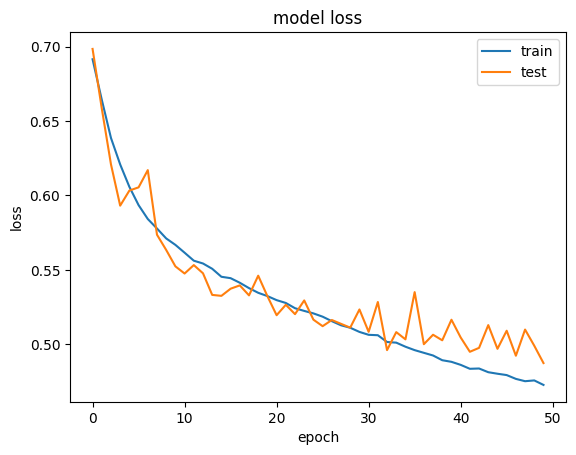

In [56]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

### Get submission predictions

In [57]:
test_pred = model.predict(data_test, batch_size=BATCH_SIZE, verbose=0)

In [58]:
# Round predictions to the nearest integer (0 or 1)
rounded_test_pred = np.round(test_pred).astype(int)

# Save the rounded predictions to a CSV file
np.savetxt('submission.csv', rounded_test_pred, fmt='%d', delimiter=',')